# Maintenance Prédictive : TP1

# 1. Couts de la maintenance : cas d'étude d'une machine outil

Dans ce premier exercice nous allons regarder quelques calculs simples sur la maintenance.

Voici les informations que vous avez à votre disposition :
*   Coût d'achat : X
*   La machine consomme en moyenne une puissance P0 kW.mois
*   Votre contrat d'électricité vous facture cette puissance au prix de T / kW.mois.
* Le constructeur vous recommande une maintenance constructeur tous les ans, qui vous coûtera M, et de faire quelques opérations de nettoyage de la machine tous les mois, qui vous coûtera m.

1.1 Quelle est la formule pour calculer le CMF ? (3')

In [1]:
# Réponse:
# CMF(a) = (X + a * (12 * (P*T + m) + M)) / a

1.2. Tracer la courbe du CMF sur vingt ans avec les hypothèses suivantes : (7'/10')

    * X = 3000
    * P0 = 10
    * T = 0.8
    * M = 10
    * m = 0.5

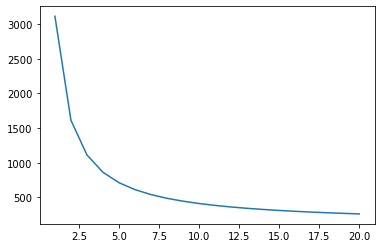

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Réponse
a = np.arange(1, 21)
X = 3000
P0 = 10
T = 0.8
M = 10
m = 0.5
cmf0 = (X + a * (12 * (P0*T + m) + M))/a
plt.plot(a, cmf0)

Nous prenons désormais l'hypothèse que la machine outil vieillit, et donc qu'elle consomme de plus en plus de puissance.P suit désormais la loi : P(a) = (P0 + exp(0.5*a))

1.3. Recalculez le CMF, puis tracer la nouvelle courbe obtenue, et comparez la aux résultats précédents. (5'/15')

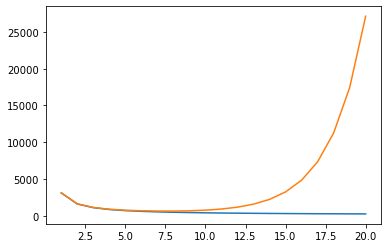

In [3]:
# réponse
dP = np.exp(0.5*a)
cmf1 = (X + a * (12 * (P0*T + m) + M) + 12 * T*np.cumsum(dP))/a
plt.plot(a, cmf0)
plt.plot(a, cmf1)

Votre machine casse au bout de 15 ans. On fait l'hypothèse que le fabricant accepte de la racheter pour la transformer en pièces détachées pour 200€, ou qu'il facturera la maintenance "au minimum" pour réparation 250€. On considère que la maintenance répare "au minimum", c'est-à-dire que la machine reste au même stade de vieillissement que si elle n'avait pas cassé. On précise que le coût d'achat et/ou le coût de maintenance est considéré l'année de l'achat/maintenance.

1.4. Est-il judicieux de la remplacer ? Commentez. (15'/30')

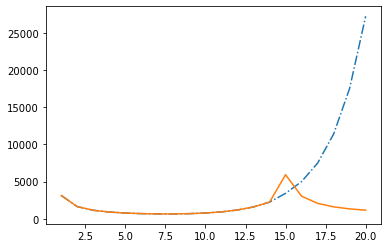

In [4]:
# Réponse (réponse à 5 aussi)
dsplit = 15
a1 =  np.arange(1, dsplit)
a2 =  np.arange(1, 21-dsplit+1)
a3 =  np.arange(dsplit, 21)

dP1 = np.exp(0.5*a1)
dP2 = np.exp(0.5*a2)
dP3 = np.exp(0.5*a3)

cmf_remplacer = np.zeros(20)

cmf_remplacer[0:dsplit-1] = (X + a1 * (12 * (P0*T + m) + M) + 12 * T * np.cumsum(dP1))/a1
cmf_remplacer[dsplit-1:] = (X + X + a2 * (12 * (P0*T + m) + M) + 12 * T * np.cumsum(dP2) - 200)/a2

cmf_reparer = np.zeros(20)
cmf_reparer[0:dsplit-1] = (X + a1 * (12 * (P0*T + m) + M) + 12 * T * np.cumsum(dP1))/a1
cmf_reparer[dsplit-1:] = (X + a3 * (12 * (P0*T + m) + M) + 12 * T * np.cumsum(dP3) + 12*T*np.sum(dP1) + 250)/a3

plt.plot(a,cmf_reparer,'-.')
plt.plot(a,cmf_remplacer)

Commentaire :
La réparation est une bonne solution court terme, cependant, pour le long terme, il vaut mieux profiter de l'occasion pour changer la machine.

1.5. A partir de quelle année il est plus rentable de changer de machine ? (2'/32')

# 2. Stratégies de maintenance
Vous disposez de machines outils, achetées à différents moments. Chaque machine casse avec une probabilité qui suit une loi de Weibull (https://fr.wikipedia.org/wiki/Loi_de_Weibull). Quand la maintenance doit arriver, votre machine est indisponible ce qui vous crée des pertes de 280€.

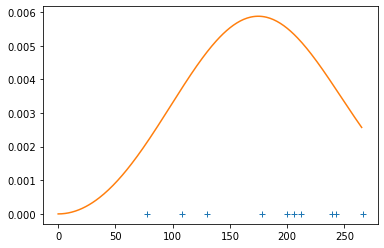

In [5]:
import matplotlib.pyplot as plt
import numpy as np
k = 3
lambda_w = 200
from scipy.stats import weibull_min
equipement_life = weibull_min.rvs(k, loc=0, scale=lambda_w, size=10)
plt.plot(equipement_life, np.zeros(10), '+')
d = np.arange(0, np.max(equipement_life))
survival = (k/lambda_w) * np.power((d/lambda_w),(k-1))*np.exp(-np.power((d/lambda_w), k))
plt.plot(d, survival)

2.1. Simulez une stratégie de maintenance corrective sur 365 jours. 30'/1h02'

In [6]:
# Réponse
limit_time = 365
cost_samples = np.zeros(1000)
for simulation in range(1000):
    cost = 0
    limite = limit_time
    tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
    while tirage < limite:
        cost += 280
        limite -= tirage
        tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
    cost_samples[simulation] = cost

print(np.mean(cost_samples))

460.32


L'un des techniciens vous propose de mettre en place une maintenance préventive. En effet, si vous prévenez le constructeur en avance, il ne vous en coûtera que 65 €, car la réparation aura lieu la nuit.

2.2. Quelle est la période qui vous paraît le plus approprié ? Faites des simulations. (30'/1h30)

In [7]:
# Réponse
period_to_be_tested = np.arange(1, 364, 25)
nb_sample = 1000
period_cost = np.zeros(len(period_to_be_tested))
for idp, period in enumerate(period_to_be_tested):
    cost_samples = np.zeros(nb_sample)
    for simulation in range(nb_sample):
        cost = 0
        age = 0
        # Each maintenance is planned
        for planed_maintenance in range(0, 365, period):
            # sample life of equipement after planned maintenance
            tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
            limite = period
            # If equipement lives not long enough, there is corrective maintenance (only if age is young enough)
            if tirage < limite :
                age += tirage
            else: # else, we move to next planned maintenance
                age += period
            
            while (tirage < limite) and (age < 365):
                cost += 280 
                limite -= tirage # the limit is reduced because multiple failure can occur
                tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
                age += tirage
            cost += 65
        cost_samples[simulation] = cost
    print(period, ':', np.mean(cost_samples))
    period_cost[idp] = np.mean(cost_samples)
print(period_cost)
print("Best period:", period_to_be_tested[np.argmin(period_cost)])

1 : 23725.0
26 : 984.24
51 : 555.0
76 : 385.48
101 : 361.64
126 : 347.32
151 : 373.92
176 : 420.68
201 : 378.64
226 : 396.28
251 : 417.28
276 : 446.4
301 : 484.2
326 : 508.84
351 : 555.32
[23725.     984.24   555.     385.48   361.64   347.32   373.92   420.68
   378.64   396.28   417.28   446.4    484.2    508.84   555.32]
Best period: 126


Un capteur vous permet de savoir la veille de la casse que la machine va casser, et ce, avec une probabilité de 0.9. 

2.3. Sachant que le capteur coûte 25€, qu'il a un coût de fonctionnement de 0.05€ par jour, , et que la maintenance vous coutera toujours 65€, est-il pertinent de passer à une maintenance prédictive ? (30'/2h00)

In [8]:
# Réponse 
nb_sample = 1000
cost_samples = np.zeros(nb_sample)
for simulation in range(nb_sample):
    cost = 0
    limite = 365
    tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
    age = tirage
    while (tirage < limite) and age < 365:
        if np.random.rand() > 0.9:
            cost += 280
        else:
            cost += 65
        limite -= tirage
        tirage = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
        age += tirage
    cost_samples[simulation] = cost
print(np.mean(cost_samples)+25+0.05*365)

184.575


Vos machines sont désormais chaînées avec une seconde machine-outil.
Celle-ci suit une loi de Weibull différente. Sa maintenance préventive coûte 16€ (celle de la 1ère toujours 65€). Le coût de sa maintenance corrective sera de 720€.

2.4. En gardant toutes les autres hypothèses, comment proposez-vous d'adapter la stratégie de maintenance ? (faites l'hypothèse simplificatrice selon laquelle les maintenances sont simultanées, quand une machine tombe en panne, on répare les deux au coût de la maintenance corrective).

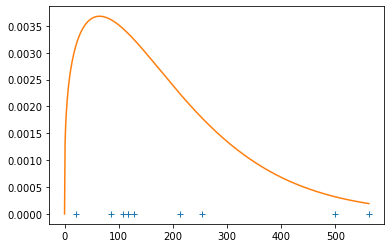

In [9]:
from scipy.stats import weibull_min
k2 = 1.3
lambda2_w = 200
equipement_life = weibull_min.rvs(k2, loc=0, scale=lambda2_w, size=10)
plt.plot(equipement_life, np.zeros(10), '+')
d = np.arange(0, np.max(equipement_life))
survival = (k2/lambda2_w) * np.power((d/lambda2_w),(k2-1))*np.exp(-np.power((d/lambda2_w), k2))
plt.plot(d, survival)

In [10]:
# Réponse
period_to_be_tested = np.arange(1, 364, 25)
nb_sample = 1000
period_cost = np.zeros(len(period_to_be_tested))
for idp, period in enumerate(period_to_be_tested):
    cost_samples = np.zeros(nb_sample)
    for simulation in range(nb_sample):
        cost = 0
        age = 0
        # Each maintenance is planned
        for planed_maintenance in range(0, 365, period):
            # sample life of equipement after planned maintenance
            tirage1 = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
            tirage2 = weibull_min.rvs(k2, loc=0, scale=lambda2_w, size=1)
            tirage = np.min([tirage1, tirage2])
            limite = period
            # If equipement lives not long enough, there is corrective maintenance (only if age is young enough)
            if tirage < limite :
                age += tirage
            else: # else, we move to next planned maintenance
                age += period
            
            while (tirage < limite) and (age < 365):
                cost += (280 + 720)
                limite -= tirage # the limit is reduced because multiple failure can occur
                tirage1 = weibull_min.rvs(k, loc=0, scale=lambda_w, size=1)
                tirage2 = weibull_min.rvs(k2, loc=0, scale=lambda2_w, size=1)
                tirage = np.min([tirage1, tirage2])
                age += tirage
            cost += (65 + 16)
        cost_samples[simulation] = cost
    print(period, ':', np.mean(cost_samples))
    period_cost[idp] = np.mean(cost_samples)
print(period_cost)
print("Best period:", period_to_be_tested[np.argmin(period_cost)])

1 : 29894.0
26 : 2028.0
51 : 1670.0
76 : 1574.0
101 : 1669.0
126 : 1722.0
151 : 1889.0
176 : 2059.0
201 : 1989.0
226 : 2080.0
251 : 2084.0
276 : 2168.0
301 : 2356.0
326 : 2517.0
351 : 2698.0
[29894.  2028.  1670.  1574.  1669.  1722.  1889.  2059.  1989.  2080.
  2084.  2168.  2356.  2517.  2698.]
Best period: 76
